In [22]:
from icepyx import icesat2data as ipd
import numpy as np
import os
import h5py
import shutil
from pathlib import Path
from pprint import pprint

from os import listdir
from os.path import isfile, join

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
earthdata_emails = {'tsnow03':'tasha.snow@colorado.edu',
                    'fperez': 'fernando.perez@berkeley.edu',
                    'alicecima':'alice_cima@berkeley.edu',
                    'fsapienza': 'fsapienza@berkeley.edu'
                      # add your name here
                   }

user = 'fsapienza'

# ATL03 Retrieval

#### Auxiliary functions

In [9]:
def delta_lat(lat, lon, delta_m):
    return 180 * delta_m / ( np.pi * 6371000 )

def delta_lon(lat, lon, delta_m):
    return 180 * delta_m / ( np.pi * 6371000 * np.cos(lat * np.pi / 180) )

def filter(string, substr): 
    return [str for str in string if
             any(sub in str for sub in substr)] 

def file_in_dir(path):
    return [f for f in listdir(path) if isfile(join(path, f))]

#### Retrieval function

In [32]:
def read_atl03 (lat, lon, date_range, delta_m, path = "new_ATL03"):
    
    """
    Read a ATL03 file based and retieve individual photons in a window around a
    desired latitide, longitud and a range of dates. 
    """
    
    # Spatial extend
    
    window_lat = delta_lat(lat, my_lon, delta_m)
    window_lon = delta_lon(lat, my_lon, delta_m)
    
    spatial_extent = [ my_lon - window_lon, my_lat - window_lat, my_lon + window_lon, my_lat + window_lat ]
    spatial_extent = [ float(x) for x in spatial_extent ]
    
    # Retreiving the data 
    
    region_a = ipd.Icesat2Data('ATL03', spatial_extent, date_range)
    region_a.avail_granules(ids=True)
    region_a.earthdata_login(user, earthdata_emails[user])
    region_a.order_vars.append(var_list=['lat_ph', "lon_ph", "h_ph"])
    region_a.subsetparams(Coverage=region_a.order_vars.wanted)
    region_a.order_granules()
    
    region_a.download_granules(path)
    
    # Accessing one individual file
    
    flist = file_in_dir(path)
    assert len(flist) == 1, "There is not an unique file in the folder"
    fname = path + "/" + flist[0]
    
    with h5py.File(fname, 'r') as fi:
        
        print(fi.keys())
        
        my_gt = filter(fi.keys(), ["gt"])[0]          # TODO == I should not put a zero here
        
        lat_ph = fi[my_gt]['heights']["lat_ph"][:]
        lon_ph = fi[my_gt]['heights']["lon_ph"][:]
        h_ph   = fi[my_gt]['heights']["h_ph"][:]
  
    df = pd.DataFrame.from_dict({"h_ph": h_ph,
                                 "lon_ph": lon_ph,
                                 "lat_ph": lat_ph} )
    
    df = df [ (df["lat_ph"] < lat + window_lat) & (df["lon_ph"] < lon + window_lon) &
              (df["lat_ph"] > lat - window_lat) & (df["lon_ph"] > lon - window_lon) ]
    
    return df

### Example 1: Finding a lake in Greenland

In [25]:
my_lat = 68.4547
my_lon = -47.6758
date_range = ['2019-08-01','2019-08-03']

In [28]:
pho_the_ph = read_atl03(my_lat, my_lon, date_range, 1000)

Earthdata Login password:  ···········


Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000701958
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000701958 of  1  order(s) is downloaded.
Download complete
<KeysViewHDF5 ['METADATA', 'ancillary_data', 'gt2l', 'gt2r', 'orbit_info']>


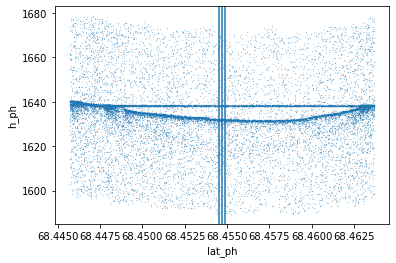

In [31]:
ax2 = pho_the_ph.plot.scatter(x='lat_ph',
                       y='h_ph',
                       #c='lat_ph',
                       s = 0.02) # colormap='viridis'
plt.axvline(x = my_lat)
plt.axvline(x = my_lat + delta_lat(my_lat, my_lon, 20))
plt.axvline(x = my_lat - delta_lat(my_lat, my_lon, 20))

A histogram can help us to see that there are two different surfaces

(array([  5.,  11.,   5.,  14.,  13.,  19.,  22.,  16.,  11.,  13.,  22.,
         16.,  24.,  19.,  18.,  18.,  21.,  15.,   8.,  21.,  14.,  26.,
         22.,  13.,  19.,  16.,  14.,  23.,  19.,  24.,  27.,  28.,  18.,
         33.,  29.,  33.,  33.,  31.,  35.,  38.,  29.,  38.,  37.,  34.,
         25.,  29.,  34.,  51.,  84., 224., 482., 481., 239.,  33.,  14.,
         19.,  20., 720.,  12.,  17.,  17.,  15.,  16.,  11.,  12.,  18.,
         10.,  23.,  16.,  17.,  15.,  16.,  14.,  17.,  12.,  15.,  16.,
         19.,  15.,  15.,  16.,  19.,   5.,  17.,   9.,  23.,  13.,  18.,
         10.,  18.,  10.,  20.,  11.,   8.,  20.,   9.,  15.,  13.,   5.,
          4.]),
 array([1589.4906, 1590.3362, 1591.1818, 1592.0273, 1592.8729, 1593.7185,
        1594.5641, 1595.4097, 1596.2552, 1597.1008, 1597.9464, 1598.792 ,
        1599.6376, 1600.4832, 1601.3287, 1602.1743, 1603.0199, 1603.8654,
        1604.7109, 1605.5565, 1606.4021, 1607.2477, 1608.0933, 1608.9388,
        1609.7844, 161

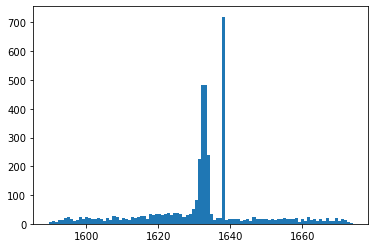

In [35]:
plt.hist(pho_the_ph["h_ph"][8000:12000], 100)

### Automatic retrieval of many locations

In [ ]:
def polygon(locations, wd = 100):

    points = sorted(locations, key=lambda x: x[0])

    polygon = []

    for x in points:
        # pairs of the form lon, lat

        polygon.append( [ x[1] - delta_lon(x[0], x[1], wd), x[0] + delta_lat(x[0], x[1], wd)] )
        polygon.append( [ x[1] + delta_lon(x[0], x[1], wd), x[0] + delta_lat(x[0], x[1], wd)] )

    for x in reversed(points):

        polygon.append( [ x[1] + delta_lon(x[0], x[1], wd), x[0] - delta_lat(x[0], x[1], wd)] )
        polygon.append( [ x[1] - delta_lon(x[0], x[1], wd), x[0] - delta_lat(x[0], x[1], wd)] )

    polygon.append(polygon[0])

    return [ [float(x[0]), float(x[1])] for x in polygon]